In [ ]:
#| default_exp data

In [ ]:
#| export
import os
import numpy as np
import pandas as pd
from copy import deepcopy
from fastcore.all import *
from fastai.vision.all import *
from andi import normalize, andi_datasets
from collections.abc import Iterable

# General definitions

We provide a set of variables with default information about the nature of the data and the default path to save it.

In [ ]:
#| export
ROOT = Path(os.path.dirname(os.path.abspath('../')))
DATA_PATH = ROOT/"data/"
DATA_PATH.mkdir(exist_ok=True, parents=True)
FIG_PATH = DATA_PATH/"figures"
FIG_PATH.mkdir(exist_ok=True, parents=True)
MODEL_DATA = {0: {'name': 'attm', 'exps': (0.05, 1.)},
              1: {'name': 'ctrw', 'exps': (0.05, 1.)},
              2: {'name': 'fbm',  'exps': (0.05, 1.95)},
              3: {'name': 'lw',   'exps': (1.05, 2.)},
              4: {'name': 'sbm',  'exps': (0.05, 2.)}}
DEFAULT_TOKEN = -1

By default, we keep the root of the repository in `ROOT`, from which we define `DATA_PATH=ROOT/data` and, subsequently, `FIG_PATH=DATA_PATH/figures`. We use these as default paths to save and load the data and the output figures.

Then, `MODEL_DATA` is a dictionary containing the information about the different anomalous diffusion models that we consider.

In [ ]:
MODEL_DATA

{0: {'name': 'attm', 'exps': (0.05, 1.0)},
 1: {'name': 'ctrw', 'exps': (0.05, 1.0)},
 2: {'name': 'fbm', 'exps': (0.05, 1.95)},
 3: {'name': 'lw', 'exps': (1.05, 2.0)},
 4: {'name': 'sbm', 'exps': (0.05, 2.0)}}

And `DEFAULT_TOKEN=-1` is the default value for the beginning of sequence token.

# Data generation

Functions to generate a segmentation dataset from scratch. There can be specified a variable number of change points, models to use, exponents, etc.

## Anomalous diffusion segmentation dataset

In [ ]:
#| export
def create_segmentation_dataset(N, max_t=200, dim=1, n_change_points=1, models=[0, 1, 2, 3, 4], 
                                exponents=np.arange(0.05, 2.01, 0.05), noise=[0.1, 0.5, 1.], 
                                path=None, save=True, **kwargs):
    "Creates a dataset for trajectory segmentation."
    n_ds = n_change_points+1
    datasets = [create_trajectories(N, max_t, exponents, models, dim, None) for _ in range(n_ds)]
    trajectories, labels, change_points = combine_trajectories(datasets, dim, **kwargs)
    trajectories, noise_amplitudes = add_localization_noise(trajectories, noise)
    seg_dataset = trajs2df(trajectories, labels, change_points, dim, noise_amplitudes)
    save_path = DATA_PATH/_get_segds_fname(n_change_points, max_t, dim) if path is None else path
    if save: seg_dataset.to_pickle(save_path)
    return seg_dataset

def trajs2df(trajectories, labels, change_points, dim, noise=None):
    "Generates dataset in `pandas.DataFrame` format transforming trajectories to `torch.Tensor`."
    data = []
    for traj, l, cp in zip(trajectories, labels, change_points):
        x, cp = tensor(traj), tensor(cp)
        length, n_cp = x.shape[1], len(cp)
        models, exps = tensor(l[::2]).to(int), tensor(l[1::2])
        y_mod, y_exp = torch.zeros(1, length, dtype=int), torch.zeros(1, length)
        lims = [0] + cp.tolist() + [None]
        for l0, l1, model, exp in zip(lims[:-1], lims[1:], models, exps): 
            s = slice(l0, l1)
            y_mod[:, s], y_exp[:, s] = model, exp
        y = torch.cat((y_mod, y_exp), dim=0)
        data.append({'dim': dim, 'len': length, 'n_cp': n_cp, 'cp': cp, 'models': models, 
                     'exps': exps, 'x': x, 'y': y, 'y_mod': y_mod, 'y_exp': y_exp})
    df = pd.DataFrame.from_records(data)
    if noise is not None: 
        df.loc[:, 'noise'] = noise
    return df

def combine_trajectories(datasets, dim, margin=10, random_lengths=False):
    "Combines the trajectories in `datasets` assigning random change_points in between."
    n_change = len(datasets) - 1
    min_t = (n_change + 1)*margin 
    n_trajs, max_t = datasets[0].shape[0], datasets[0][0, 2:].reshape(dim, -1).shape[-1]
    if max_t < min_t: 
        raise ValueError("Trajectory length must be, at least, (change points + 1) times the margin" + 
                         f". Got length {max_t} for margin {margin} and {n_change} change points.")
    lengths = (np.random.randint(min_t, max_t+1, n_trajs) if random_lengths 
               else np.ones(n_trajs, dtype=int)*max_t)
    change_points = _get_change_points(n_change, lengths, margin)
    datasets = _permute_datasets(datasets)
    trajectories, labels = [], []
    for n in range(n_trajs):
        trajs = [datasets[c][n, 2:] for c in range(n_change+1)]
        trajectories.append(_merge_trajectories(trajs, change_points[n], dim, max_t=lengths[n]))
        labels.append(np.concatenate([datasets[c][n, :2] for c in range(n_change+1)]))
    return trajectories, labels, change_points

create_segmentation_dataset = delegates(to=combine_trajectories)(create_segmentation_dataset)
                
def _add_permutation_sample(repeated, datasets, idx):
    "Checks conditions in order add an additional sample from which to perform permutations"
    check_length = len(repeated) <= 2
    check_ds = [len(np.unique(ds[i[repeated], 0]))==1 or len(np.unique(ds[i[repeated], 1]))==1 
                for ds,i in zip(datasets, idx)]
    return check_length or np.any(check_ds)
      
def _merge_trajectories(trajs, change_points, dim, max_t=None):
    "Merges trajectories `trajs` with `change_points` accounting for dimension."
    trajs = [traj.reshape(dim, -1) for traj in trajs]
    cps = [0] + list(change_points) + [max_t]
    slices = [slice(cps[c], cps[c+1]) for c in range(len(cps)-1)]
    offsets = [np.zeros((dim, 1))] + [np.expand_dims(t1[:, c] - t2[:, c], -1) 
                                      for t1, t2, c in zip(trajs[:-1], trajs[1:], change_points)]
    offsets = np.cumsum(offsets, axis=0)
    return np.concatenate([traj[:, s]+o for traj, s, o in zip(trajs, slices, offsets)], axis=1)
    
def _get_change_points(n_change, lengths, margin):
    n_trajs = lengths.shape[0]
    change_points = np.zeros((n_trajs, n_change), dtype=int)
    if n_change == 1:
        change_points[:, 0] = np.random.randint(margin, lengths-margin, n_trajs)
        return change_points
    
    change_points[:, 0] = np.random.triangular(margin, margin, lengths-n_change*margin, n_trajs).astype(int)
    for n in range(n_change-1):
        min_t, max_t = change_points[:, n]+margin, lengths-(n_change-n-1)*margin
        if n < n_change - 2:
            change_points[:, n+1] = np.random.triangular(min_t, min_t, max_t, n_trajs).astype(int)
        else: 
            change_points[:, n+1] = np.random.randint(min_t, max_t, n_trajs)
    # Workaround to account for imbalances in sampling. Works decently until n_change=4
    mask = np.random.randint(0, 2, n_trajs, dtype=bool)
#     change_points[mask] = np.sort(np.abs(change_points[mask] - lengths[mask, None]))
    return change_points

def _permute_datasets(datasets, max_iter=1000):
    "Permutes datasets to prevent having the same labels in contiguous segments."
    n_traj = datasets[0].shape[0]
    idx = [np.random.permutation(n_traj) for ds in datasets]
    for d in range(1, len(datasets)):
        i = slice(d-1, d)
        diff = np.abs(datasets[d-1][idx[d-1], :2] - datasets[d][idx[d], :2]).sum(1)
        repeated = np.argwhere(diff==0)[:, 0]
        it = 0
        while len(repeated) > 0 and it < max_iter:
            if _add_permutation_sample(repeated, datasets[i], idx[i]): 
                repeated = np.append(repeated, np.random.randint(0, n_traj))
                idx[d][repeated] = idx[d][np.random.permutation(repeated)]
            else:                  
                idx[d][repeated] = idx[d][np.random.permutation(repeated)]
            diff = np.abs(datasets[d-1][idx[d-1], :2] - datasets[d][idx[d], :2]).sum(1)
            repeated = np.argwhere(diff==0)[:, 0]
            it += 1
        if it == max_iter: 
            for k in range(len(datasets)):
                idx[k] = np.delete(idx[k], repeated, axis=0)
    
    return [ds[i] for ds,i in zip(datasets, idx)]

def create_trajectories(N, max_t, exponents, models, dim, noise=[0.1, 0.5, 1.]):
    ad = andi_datasets()
    n_per_class = _get_balanced_dataset_numbers(N, exponents, models)
    dataset = ad.create_dataset(T=max_t, N=n_per_class, exponents=exponents, 
                                dimension=dim, models=models)
                                # save_trajectories=True, path=DATA_PATH, t_save=200

    # Normalize trajectories
    n_traj = dataset.shape[0]
    norm_trajs = normalize(dataset[:, 2:].reshape(n_traj*dim, max_t))
    dataset[:, 2:] = norm_trajs.reshape(dataset[:, 2:].shape)

    # Add localization error, Gaussian noise with
    if noise is not None:
        noisy_trajs, _ = add_localization_noise(dataset[:, 2:].reshape(n_traj, dim, -1), 
                                                noise_amplitude=noise)
        dataset[:, 2:] = noisy_trajs.reshape(dataset[:, 2:].shape)

    # Add random diffusion coefficients
    trajs = dataset[:, 2:].reshape(n_traj*dim, max_t)
    displacements = trajs[:, 1:] - trajs[:, :-1]
    # Get new diffusion coefficients and displacements
    diffusion_coefficients = np.random.randn(trajs.shape[0])
    new_displacements = (displacements.transpose()*diffusion_coefficients).transpose()  
    # Generate new trajectories and add to dataset
    new_trajs = np.cumsum(new_displacements, axis=1)
    new_trajs = np.concatenate((np.zeros((new_trajs.shape[0], 1)), new_trajs), axis=1)
    dataset[:, 2:] = new_trajs.reshape(dataset[:, 2:].shape)
    
    return dataset

def add_localization_noise(trajs, noise_amplitude=[0.01, 0.5, 1]):
    "Adds white noise with standard deviation `noise_amplitude`."
    noise_amp = np.random.choice(np.array(noise_amplitude), size=len(trajs))
    try: 
        trajs = np.array(trajs)
        noise = np.random.randn(*trajs.shape)*noise_amp[:, None, None]
        noisy_trajs = trajs + noise - noise[:, :, 0, None]
    except:
        noisy_trajs = [t + na*np.concatenate((np.zeros((t.shape[0], 1)), 
                                              np.random.randn(*t[:, :-1].shape)), axis=-1) 
                       for t, na in zip(trajs, noise_amp)]     
    return noisy_trajs, noise_amp
    
def _get_balanced_dataset_numbers(N, exponents, models):
    n_exp, n_models = len(exponents), len(models)
    n_per_model = N/n_models
    n_per_class = np.zeros((n_models, n_exp))
    for m, model in enumerate(models):
        which_exps = (MODEL_DATA[model]['exps'][0] <= exponents) & (exponents <= MODEL_DATA[model]['exps'][1])
        n_per_class[m, which_exps] = round(n_per_model/sum(which_exps))
    return n_per_class

def _get_segds_fname(n_change_points, max_t, dim):
    "Returns standardized file name for segmentation dataset."
    return f"segds_{n_change_points}changes_T{max_t}_dim{dim}.pkl"

In [ ]:
#| include: false
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
N = 100
df = create_segmentation_dataset(N, save=False)

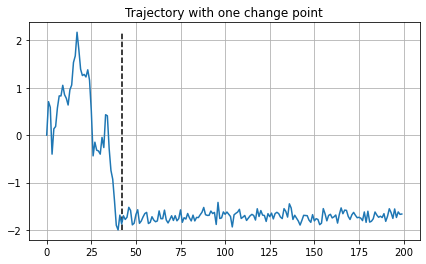

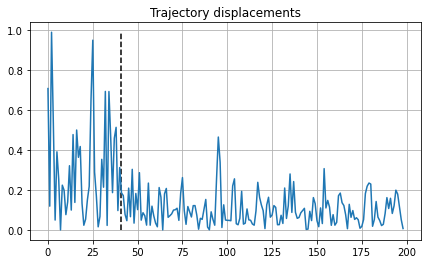

In [ ]:
#| code-fold: true
plt.figure(figsize=(7,4))
plt.plot(x0.x[0])
plt.vlines(x0.cp.item(), min(x0.x[0]), max(x0.x[0]), linestyles='dashed', colors='k')
plt.grid()
plt.title("Trajectory with one change point")

displ = abs(x0.x[0, :-1] - x0.x[0, 1:])
plt.figure(figsize=(7,4))
plt.plot(displ)
plt.vlines(x0.cp.item()-1, min(displ), max(displ), linestyles='dashed', colors='k')
plt.grid()
plt.title("Trajectory displacements");

## Brownian motion 

In [ ]:
#| export
@delegates(combine_trajectories)
def create_bm_segmentation_dataset(N, max_t=200, dim=1, n_change_points=1, 
                                   Ds=None, path=None, save=True, **kwargs):
    "Creates a segmentation dataset to tell between diffusion coefficients."
    n_ds = n_change_points + 1
    Ds = np.logspace(-3, 3, N//100) if Ds is None else Ds
    datasets = [create_bm_trajectories(N, max_t, Ds=Ds, dim=dim) for _ in range(n_ds)]
    trajectories, labels, change_points = combine_trajectories(datasets, dim, **kwargs)
    seg_dataset = trajs2df(trajectories, labels, change_points, dim)
    save_path = DATA_PATH/_get_bmds_fname(n_change_points, max_t, dim) if path is None else path
    if save: seg_dataset.to_pickle(save_path)
    return seg_dataset

def brownian_motion(N, max_t, D, dim=1, dt=1):
    "Creates `N` `dim`-dimensional trajectories with diffusion coefficient `D`."
    bm = (np.sqrt(2*D*dt)*np.random.randn(N, dim, max_t)).cumsum(-1)
    return bm - bm[:, :, 0, None]

@delegates(brownian_motion)
def create_bm_trajectories(N, max_t, Ds=[1.], shuffle=True, **kwargs):
    "Creates `N` Brownian Motion trajectories."
    if not isinstance(Ds, Iterable): Ds = [Ds]
    n_per_d = N//len(Ds)
    Ds = np.repeat(np.array(Ds), n_per_d)
    bms = brownian_motion(len(Ds), max_t, Ds[:, None, None], **kwargs)
    info = np.tile(Ds, (2, 1)).T
    trajs = np.concatenate((info, bms.reshape(info.shape[0], -1)), -1)
    return np.random.permutation(trajs) if shuffle else trajs

def _get_bmds_fname(n_change_points, max_t, dim):
    "Returns standardized file name for segmentation dataset."
    return f"bmds_{n_change_points}changes_T{max_t}_dim{dim}.pkl"

In [ ]:
bm_trajs = create_bm_trajectories(20000, 200, Ds=np.logspace(-3, 3, 13), shuffle=False)

In [ ]:
traj_idx, D, D_log, trajectories = [], [], [], [] 
for idx, traj in enumerate(bm_trajs):
    info, x = traj[:2], traj[2:]
    ones = np.ones_like(x)
    traj_idx.append(ones*idx)
    D.append(ones*info[0])
    D_log.append(ones*np.log10(info[0]))
    trajectories.append(x)
    
df = pd.DataFrame({'traj_idx': np.concatenate(traj_idx), 'D': np.concatenate(D),
                   'D_log': np.concatenate(D_log), 'x': np.concatenate(trajectories)})

In [ ]:
df.to_csv(DATA_PATH/'bm_trajectories_1D_200t.csv')

In [ ]:
N = 100
df = create_bm_segmentation_dataset(N, Ds=[10, 50, 100], save=False)

In [ ]:
x0 = df.iloc[0]
x0.models, x0.exps, x0.cp, x0.x.shape

(tensor([80, 29]),
 tensor([80.1273, 29.1402]),
 tensor([158]),
 torch.Size([2, 200]))

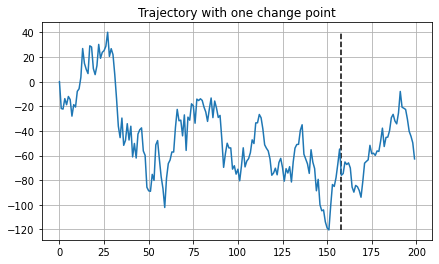

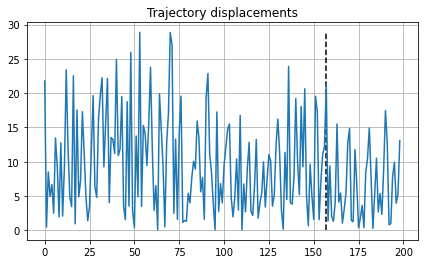

In [ ]:
#| code-fold: true
plt.figure(figsize=(7,4))
plt.plot(x0.x[0])
plt.vlines(x0.cp.item(), min(x0.x[0]), max(x0.x[0]), linestyles='dashed', colors='k')
plt.grid()
plt.title("Trajectory with one change point")

displ = abs(x0.x[0, :-1] - x0.x[0, 1:])
plt.figure(figsize=(7,4))
plt.plot(displ)
plt.vlines(x0.cp.item()-1, min(displ), max(displ), linestyles='dashed', colors='k')
plt.grid()
plt.title("Trajectory displacements");

## ATTM dataset

In [ ]:
#| export
def create_fixed_attm_trajs(n_traj, max_t, sigma, gamma):
    "Creates 2-D ATTM trajectories with fixed sigma and gamma."
    trajs = np.zeros((n_traj, 2, max_t))
    Ds = np.zeros((n_traj, max_t))
    t0, t1 = np.ones(n_traj, dtype=int), np.zeros(n_traj, dtype=int)
    idx = np.arange(n_traj)
    while (t0 < max_t).any():
        not_done = t0 < max_t 
        D = (1 - np.random.uniform(low=0.1, high=0.99, size=not_done.sum()))**(1/sigma)
        t1[not_done] = t0[not_done] + (D**(-gamma)).astype(int)
        t1 = np.where((t1 > max_t) & not_done, max_t, t1)
        dt = t1 - t0
        for i, d in zip(idx[not_done], D):
            trajs[i, : , t0[i]:t1[i]] = (np.expand_dims(trajs[i, :, t0[i]-1], -1)
                                         + brownian_motion(1, dt[i]+1, d, dim=2)[0, :, 1:])
            Ds[i, t0[i]:t1[i]] = d
        t0 = np.copy(t1)
    Ds[:, 0] = Ds[:, 1]
    return trajs, Ds

In [ ]:
np.random.seed(7)
trajs, ds = create_fixed_attm_trajs(2, 15, 0.3, 0.4)

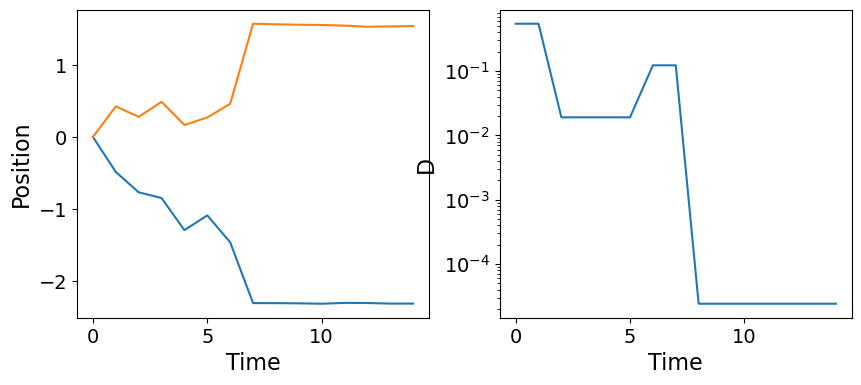

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(trajs[0].T)
axes[0].set_xlabel("Time", fontsize=16)
axes[0].set_ylabel("Position", fontsize=16)
axes[0].tick_params(labelsize=14)

axes[1].semilogy(ds[0])
axes[1].set_xlabel("Time", fontsize=16)
axes[1].set_ylabel("D", fontsize=16)
axes[1].tick_params(labelsize=14)

## Datasets with variable number of change points

So far we can build datasets with a fixed number of changepoints. In order to make a dataset which contains a variable number of change points, we can simply combine several of those in a smart way.

In [ ]:
#| export
def combine_datasets(datasets, shuffle=True):
    dataset = pd.concat(datasets, ignore_index=True)
    if shuffle: dataset = dataset.sample(frac=1).reset_index(drop=True)
    return dataset

### Brownian motion

In [ ]:
N_per_set = 12000
max_t = 200
dim = 2
Ds = np.logspace(-3, 3, 1000) 
cps = [1, 2, 3, 4]
# Choose a function to create datasets either brownian motion or anomalous diffusion
ds_fun = partial(create_bm_segmentation_dataset, max_t=max_t, dim=dim, Ds=Ds, save=False)

In [ ]:
datasets = [ds_fun(N_per_set, n_change_points=n_cp) for n_cp in cps]
dataset = combine_datasets(datasets)

save_path = DATA_PATH/_get_bmds_fname(f'{min(cps)}_to_{max(cps)}_test', max_t, dim)
dataset.to_pickle(save_path)

### Anomalous diffusion

In [ ]:
N_per_set = 15000
max_t = 200
dim = 2 
cps = [1, 2, 3, 4]
# Choose a function to create datasets either brownian motion or anomalous diffusion
ds_fun = partial(create_segmentation_dataset, models=[2, 4], max_t=max_t, dim=dim, noise=[0.], save=False)

In [ ]:
datasets = [ds_fun(N_per_set, n_change_points=n_cp) for n_cp in cps]
dataset = combine_datasets(datasets)

save_path = DATA_PATH/_get_segds_fname(f'{min(cps)}_to_{max(cps)}_fbm_sbm_no_noise', max_t, dim)
dataset.to_pickle(save_path)

(1, tensor([164]), tensor([2, 1]), tensor([0.3000, 0.9000]), 0.1)

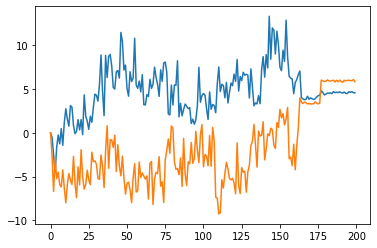

In [ ]:
idx = 3
plt.plot(dataset.x[idx].T)
dataset.n_cp[idx], dataset.cp[idx], dataset.models[idx], dataset.exps[idx], dataset.noise[idx]

# Validation with AnDi

In [ ]:
#| export
def load_andi_data(dim=1, task=1):
    path = DATA_PATH/f'andi_val_{task}'
    try: 
        df = pd.read_pickle(path.with_suffix(".pkl"))
    except: 
        _txt2df(path)
        df = pd.read_pickle(path.with_suffix(".pkl"))    
    return df[df['dim']==dim].reset_index(drop=True)

def _txt2df(path):
    "Extracts dataset and saves it in df form"
    txt_path = path.with_suffix(".txt")
    toy_y = tensor([])
    data = []
    with open(txt_path, 'r') as f:
        trajs = csv.reader(f, delimiter=";", lineterminator="\n", quoting=csv.QUOTE_NONNUMERIC)
        for t in trajs:
            dim, x = int(t[0]), tensor(t[1:])
            x = x.view(dim, -1)
            data.append({'dim': dim, 'len': x.shape[1], 'x': x, 'y': toy_y})
    df = pd.DataFrame.from_records(data)
    df.to_pickle(path.with_suffix(".pkl"))

In [ ]:
df = load_andi_data(dim=2)

In [ ]:
df.shape

(10000, 4)

In [ ]:
df.head(2)

,dim,len,x,y
0,2,200,"[[tensor(0.), tensor(-0.5156), tensor(-0.8383), tensor(-1.4615), tensor(-1.7552), tensor(-1.6362), tensor(-1.4192), tensor(-1.3548), tensor(-1.2144), tensor(-1.7406), tensor(-1.6199), tensor(-1.4474), tensor(-0.2902), tensor(0.5447), tensor(0.5666), tensor(0.1618), tensor(-0.1004), tensor(-0.1377), tensor(-1.1998), tensor(-1.9200), tensor(-3.1992), tensor(-4.4678), tensor(-5.7045), tensor(-6.3007), tensor(-6.6895), tensor(-7.5415), tensor(-7.9907), tensor(-9.3120), tensor(-10.1935), tensor(-10.5246), tensor(-11.5122), tensor(-12.5124), tensor(-13.6076), tensor(-13.9701), tensor(-14.3846), ...",[]
1,2,200,"[[tensor(0.), tensor(1.8434), tensor(2.5901), tensor(3.3360), tensor(3.3675), tensor(5.1754), tensor(6.7046), tensor(6.5266), tensor(5.5823), tensor(4.2652), tensor(2.6675), tensor(2.0960), tensor(1.3606), tensor(-0.0349), tensor(-1.4965), tensor(-0.4068), tensor(-1.8796), tensor(-1.7324), tensor(-1.8430), tensor(-0.4918), tensor(0.8988), tensor(1.1704), tensor(2.8995), tensor(3.4126), tensor(3.3071), tensor(4.3777), tensor(4.9901), tensor(6.3406), tensor(7.1728), tensor(8.1412), tensor(9.1267), tensor(9.0713), tensor(9.1243), tensor(11.2437), tensor(12.1926), tensor(12.3969), tensor(12.98...",[]


# DataLoaders

Data loading functionalities.

In [ ]:
#| export
def load_dataset(n_change=1, max_t=200, dim=1, path=None, bm=False):
    "Loads dataset according to `n_change`, `max_t` and `dim` or straight from `path`."
    name_fn = _get_bmds_fname if bm else _get_segds_fname
    load_path = DATA_PATH/name_fn(n_change, max_t, dim) if path is None else path
    return pd.read_pickle(load_path)

@delegates(TfmdLists.dataloaders)
def get_transformer_dls(target='y_mod', dim=1, n_change=1, max_t=200, valid_pct=0.2, models=None,
                        exps=None, size=None, data_path=None, init_token=None, **kwargs):
    "Obtain `DataLoaders` from filtered dataset prepared for transformer training."
    ds = load_dataset(n_change=n_change, max_t=max_t, dim=dim, path=data_path)
    if models is not None or exps is not None: ds = _filter_dataset(ds, models, exps, n_change)
    if size is not None and size <= ds.shape[0]: ds = _subsample_dataset(ds, size)
    n_class = _get_n_class(target, ds)
    splits = RandomSplitter(valid_pct=valid_pct)(list(ds.index))
    tfm = SegmentationTransform(target=target, n_class=n_class, init_token=init_token)
    tfl = TfmdLists(ds, tfm, splits=splits)
    return tfl.dataloaders(**kwargs)

class SegmentationTransform(Transform):
    def __init__(self, target='y_mod', n_class=5, init_token=None):
        "Transform to process rows from dataset in `pandas.DataFrame` format."
        store_attr('target,n_class,init_token')
        self.one_hot_encode = target == 'y' or target == 'y_mod'
        
    def encodes(self, row):
        x, y = self._get_xy(row)
        y_one_hot = _one_hot_encode(y, self.n_class) if self.one_hot_encode else deepcopy(y)
        y_one_hot = _prepend_initial_token(y_one_hot, self.init_token)
        return (x, y_one_hot.squeeze(), y.squeeze())
        
    def _get_xy(self, row):
        return row['x'].transpose(1,0), row[self.target].transpose(1,0)
    
@delegates(load_dataset)
def get_segmentation_dls(target='y_mod', models=None, exps=None, size=None, bs=128, 
                         split_pct=0.2, shuffle=True, tfm_y=None, **kwargs):
    "Obtain `DataLoaders` from dataset filtered by `models` and `exps` to predict `target`."
    ds = load_dataset(**kwargs)
    if models is not None or exps is not None: ds = _filter_dataset(ds, models, exps, n_change)
    if size is not None and size <= ds.shape[0]: ds = _subsample_dataset(ds, size)
    x = ds['x'].map(partial(torch.transpose, dim0=1, dim1=0))
    y = ds[target].map(torch.squeeze)
    if tfm_y is not None: y = y.map(tfm_y)
    ds = L(zip(x, y))
    return _get_dls_from_ds(ds, split_pct=split_pct, bs=bs, shuffle=shuffle)

@delegates(load_andi_data)
def get_andi_valid_dls(bs=128, pct=1, **kwargs):
    "Obtain `DataLoaders` from AnDi challenge validation data."
    ds = load_andi_data(**kwargs)
    x = ds['x'].map(partial(torch.transpose, dim0=1, dim1=0))
    y = ds['y']
    ds = L(zip(x, y))
    return _get_dls_from_ds(ds, split_pct=pct, bs=bs, shuffle=False)

def _get_dls_from_ds(ds, split_pct=0.2, bs=128, shuffle=True):
    idx = torch.randperm(len(ds)) if shuffle else tensor(range(len(ds)))
    cut = int(len(ds)*split_pct)
    train_ds, val_ds = ds[idx[cut:]], ds[idx[:cut]]
    return DataLoaders.from_dsets(train_ds, val_ds, bs=bs, shuffle=shuffle)

def _one_hot_encode(sample, n_class=5):
    "One-hot encodes the labels in sample."
    idx = sample[:, 0].long().unsqueeze(-1)
    one_hot_sample = torch.zeros(idx.shape[0], n_class)
    one_hot_sample.scatter_(-1, idx, 1)
    if sample.shape[1] == 2: one_hot_sample[:, -1] = deepcopy(sample[:, -1])
    return one_hot_sample

def _prepend_initial_token(sample, token=None):
    "Prepends an initial token into the sample trajectory dropping the last point."
    if token is None: token = DEFAULT_TOKEN * torch.ones([1, sample.shape[1]])
    return torch.cat([token, sample[:-1]], dim=0)

def _get_n_class(task, df):
    "Figures the output size for the `task` (prediction target) given the dataset `df`."
    if task == 'y_exp': return 1
    else: 
        n_class = len(torch.cat(tuple(df['models'])).unique())
        if task == 'y': n_class += 1
    return n_class

def _filter_dataset(dataset, models=None, exps=None, n_change=1):
    "Returns dataset filtered by `models` and `exps`."
    if models is not None: dataset = dataset[_check_in(dataset.models, models, n_change)]
    if exps is not None:   dataset = dataset[_check_in(dataset.exps, exps, n_change)]
    return dataset
    
def _check_in(series, objects, n_change):
    "Checks whether objects are in elements of a given `pandas.Series`."
    return sum([series.apply(lambda x: o in x) for o in objects]) > n_change

def _subsample_dataset(dataset, n_max):
    "Takes `n_max` samples from `dataset` in `pandas.DataFrame` format."
    return dataset.sample(n_max).reset_index(drop=True)

Transformer data loaders provide three items: raw trajectory (src), one-hot encoding of labels (tgt) and the labels to compute the loss. 

In [ ]:
tfm_dls = get_transformer_dls(size=100, bs=4)

In [ ]:
x, y_one_hot, y = tfm_dls.one_batch()
x.shape, y_one_hot.shape, y.shape

(torch.Size([4, 200, 1]), torch.Size([4, 200, 5]), torch.Size([4, 200]))

In [ ]:
idx = 0
x[idx, :5], y_one_hot[idx, :5], y[idx, :5]

(tensor([[ 0.0000],
         [-0.0976],
         [-0.0456],
         [ 0.0426],
         [ 0.0395]], device='cuda:0'),
 tensor([[-1., -1., -1., -1., -1.],
         [ 0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  1.,  0.,  0.]], device='cuda:0'),
 tensor([2, 2, 2, 2, 2], device='cuda:0'))

Segmentation dataloaders simply provide the raw trajectories with their corresponding labels.

In [ ]:
seg_dls = get_segmentation_dls(size=100, bs=4)

In [ ]:
x, y = seg_dls.one_batch()
x.shape, y.shape

(torch.Size([4, 200, 1]), torch.Size([4, 200]))

In [ ]:
x[0, :5], y[0, :5]

(tensor([[0.0000],
         [3.3110],
         [4.2102],
         [7.4056],
         [4.6176]]),
 tensor([3, 3, 3, 3, 3]))

Validation with AnDi

In [ ]:
andi_dls = get_andi_valid_dls(dim=2)

In [ ]:
x, y = andi_dls.valid.one_batch()

In [ ]:
x.shape, y.shape

(torch.Size([128, 200, 2]), torch.Size([128, 0]))

In [ ]:
x[0, :5]

tensor([[ 0.0000,  0.0000],
        [-0.5156,  0.5875],
        [-0.8383,  0.5096],
        [-1.4615,  0.5320],
        [-1.7552,  0.4109]])

# Export-

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_data.ipynb.
Converted 01_models.ipynb.
Converted 02_utils.ipynb.
Converted 03_baselines.ipynb.
Converted index.ipynb.
